## Соревнование How good is your Medium article?

#### Описание:
The training set is comprised of 62313 articles published on Medium before July 1, 2017. (train.json.gz, ungzipped ~2.1 Gb). The test set contains 34645 articles published on Medium from July 1, 2017 till March 3, 2018. (test.json.gz, ungzipped ~1.16 Gb).

#### Цель:
предсказать число рекомендаций для статьи на medium

#### Данные:
* id статьи
* дата публикации
* автор публикации
* content - текст статьи в html формате
* meta_tags - дополнительная информация

In [4]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import vstack, hstack, csc_matrix
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit,\
                                    cross_val_score, cross_validate, GridSearchCV, ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from tqdm import tqdm_notebook
from collections import defaultdict
import time
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
import json
from bs4 import BeautifulSoup
import re
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
import gc

In [5]:
# функция для чтения json файлов
def read_json(path_to_file):
    with open(path_to_file) as fin:
        for line in fin: 
            yield json.loads(line)

In [6]:
# пути к файлам, размеры файлов
PATH_TR, PATH_TE = 'train.json', 'test.json'
LEN_TR, LEN_TE = 62313, None
y_tr = pd.read_csv('train_log1p_recommends.csv', index_col='id')['log_recommends'].values
IDX_SPLIT = np.int32(LEN_TR*.9)
NFOLDS = 3
SEED = 13

In [7]:
def _clean_text(string):
    '''
    чистит текст от пунктуации, эмоджи, приводит к нижнему регистру
    '''
    # приводим к нижнему регистру
    string_lower = string.lower().strip()  
    # удаляем пунктуацию
    punctuation = "!@#$%^&*()_+<>?:.,;-«»–“”''" 
    for c in string_lower:
        if c in punctuation:
            string_lower = string_lower.replace(c, "")  
    string_lower = string_lower.replace('medium', "").strip()
    
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  
            u"\U0001F300-\U0001F5FF"  
            u"\U0001F680-\U0001F6FF"  
            u"\U0001F1E0-\U0001F1FF"  
                               "]+", flags=re.UNICODE)
    # удаляем эмоджи
    string_lower = emoji_pattern.sub(r'', string_lower).strip()    
    return string_lower

In [8]:
# D = defaultdict(list)
# for article in tqdm_notebook(read_json(PATH_TR), total = LEN_TR):    
    
#     D['_id'].append(article['_id'])
#     D['_timestamp'].append(article['_timestamp'])
#     D['_spider'].append(article['_spider'])
#     D['url'].append(article['url'])
#     D['domain'].append(article['domain'])
#     D['published_date'].append(pd.Timestamp(article['published']['$date']))

#     # название статьи (чистим от пунктуации, приводим к нижнему регистру, удаляем лишние пропуски)
#     D['title'].append(_clean_text(article['title']))
    
#     # чистим текст от html тэгов
#     text = BeautifulSoup(article['content'], "lxml").text    
#     D['text'].append(_clean_text(text))
    
#     # автор
#     if article['author']['name'] is None:
#         D['name'].append(np.nan)
#     else:
#         D['name'].append(name)

#     # url статьи
#     if article['author']['url'] is None:
#         D['url'].append(np.nan)
#     else:
#         D['url'].append(article['author']['url'])

#     # twitter автора
#     if article['author']['twitter'] is None:
#         D['twitter'].append(np.nan)
#     else:
#         D['twitter'].append(article['author']['twitter'])
        
# # with open ('D.pickle', 'wb') as f:
# #     pickle.dump(D, f)

In [9]:
with open ('D.pickle', 'rb') as f:
    D = pickle.load(f)

#### целевая переменная

In [10]:
def inv_boxcox(y,ld):
    '''обратное преобразование бокса-кокса'''
    if ld == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(ld*y+1)/ld))

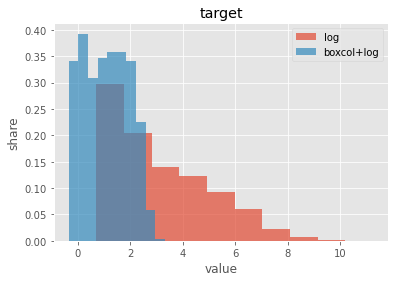

In [11]:
# box-cox преобразование(чтобы исправить сильную скошенность)
y_boxcox_tr, ld = stats.boxcox(y_tr)

plt.hist(y_tr, density = 1, alpha = .7)
plt.hist(y_boxcox_tr, density = 1, alpha = .7)
plt.legend(['log', 'boxcol+log'])
plt.title('target')
plt.ylabel('share')
plt.xlabel('value')
plt.show()

In [12]:
D.keys()

dict_keys(['_id', '_timestamp', '_spider', 'url', 'domain', 'published_date', 'title', 'text', 'name', 'twitter'])

In [13]:
lin_reg = LinearRegression()
ridge_reg = Ridge(random_state = SEED)
lasso_reg = Lasso(random_state = SEED)
lgb_reg = LGBMRegressor(random_state = SEED)

#### title

In [14]:
title_tfidf_param_grid = {'ngram_range':[(1, i) for i in range(1, 11)],\
                          'max_features':[1e1, 1e2, 1e3, 1e4, 1e5, 1e6]}                 

L_title = []
for ngram_range in tqdm_notebook(title_tfidf_param_grid['ngram_range']):
    for max_features in tqdm_notebook(title_tfidf_param_grid['max_features']):
        vectorizer = TfidfVectorizer(ngram_range = ngram_range, max_features = int(max_features))
        tfidf_tr = csc_matrix(vectorizer.fit_transform(D['title']))
        lgb_mean_cv = cross_validate(lgb_reg, tfidf_tr[:IDX_SPLIT], y_boxcox_tr[:IDX_SPLIT],
               cv=NFOLDS,
               scoring = 'neg_mean_absolute_error')['test_score'].mean()
        ridge_mean_cv = cross_validate(ridge_reg, tfidf_tr[:IDX_SPLIT], y_boxcox_tr[:IDX_SPLIT],
               cv=NFOLDS,
               scoring = 'neg_mean_absolute_error')['test_score'].mean()
        lasso_mean_cv = cross_validate(lasso_reg, tfidf_tr[:IDX_SPLIT], y_boxcox_tr[:IDX_SPLIT],
               cv=NFOLDS,
               scoring = 'neg_mean_absolute_error')['test_score'].mean()
        linreg_mean_cv = cross_validate(lin_reg, tfidf_tr[:IDX_SPLIT], y_boxcox_tr[:IDX_SPLIT],
               cv=NFOLDS,
               scoring = 'neg_mean_absolute_error')['test_score'].mean()
        L_title.append((ngram_range, max_features, lgb_mean_cv, ridge_mean_cv, lasso_mean_cv, linreg_mean_cv))
        del tfidf_tr, lgb_mean_cv, ridge_mean_cv, lasso_mean_cv, linreg_mean_cv
        gc.collect()

In [15]:
cvAB_title = pd.DataFrame(L_title, columns = ['ngram_range', 'max_features',\
                                              'lgb_mean_cv', 'ridge_mean_cv',\
                                              'lasso_mean_cv','linreg_mean_cv'])
cvAB_title.iloc[cvAB_title.iloc[:, 2:].max(1).idxmax()]

ngram_range          (1, 3)
max_features      1000000.0
lgb_mean_cv       -0.662311
ridge_mean_cv     -0.638334
lasso_mean_cv     -0.749675
linreg_mean_cv    -0.625188
Name: 17, dtype: object

#### text

In [ ]:
text_tfidf_param_grid = {'ngram_range':[(1, i) for i in np.arange(1, 3)],\
                         'max_features':[1e6]}                 

L_text = []
for ngram_range in tqdm_notebook(text_tfidf_param_grid['ngram_range']):
    for max_features in tqdm_notebook(text_tfidf_param_grid['max_features']):
        vectorizer = TfidfVectorizer(ngram_range = ngram_range, max_features = int(max_features))
        
        tfidf_tr = csc_matrix(vectorizer.fit_transform(D['text']))
        linreg_mean_cv = cross_validate(lin_reg, tfidf_tr[:IDX_SPLIT], y_boxcox_tr[:IDX_SPLIT],
               cv=NFOLDS,
               scoring = 'neg_mean_absolute_error')['test_score'].mean()  
        ridge_mean_cv = cross_validate(ridge_reg, tfidf_tr[:IDX_SPLIT], y_boxcox_tr[:IDX_SPLIT],
               cv=NFOLDS,
               scoring = 'neg_mean_absolute_error')['test_score'].mean()   
        L_text.append((ngram_range, max_features, ridge_mean_cv, linreg_mean_cv))
        del ridge_mean_cv, linreg_mean_cv, tfidf_tr
        gc.collect()

In [ ]:
cvAB_text = pd.DataFrame(L_text, columns = ['ngram_range', 'max_features',\
                                              'lgb_mean_cv', 'ridge_mean_cv',\
                                              'lasso_mean_cv', 'linreg_cv'])
cvAB_text.iloc[cvAB_text.iloc[:, 2:].max(1).idxmax()]